In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tqdm
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.base import TransformerMixin

from glob import glob

import xgboost as xgb

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

import torchvision
from torchvision.transforms import functional as F
from torchvision import models, transforms
import torchvision.transforms as transforms

from PIL import Image

import warnings
warnings.filterwarnings('ignore')
torch.cuda.get_device_name(0)

c:\Users\user\anaconda3\envs\datascience\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'NVIDIA GeForce RTX 3050 6GB Laptop GPU'

In [3]:
train_meta = pd.read_csv(rf"datasets\ISIC\train-metadata.csv")
train_meta

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,IL_9520694,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,IL_9852274,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000


In [4]:
print("len data", len(train_meta))
train_meta.info()

len data 401059
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                 

In [5]:
train_meta.columns

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', '

In [6]:
excluded = ['patient_id', 'image_type', 'iddx_full', 'lesion_id', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index', 'attribution', 'copyright_license', 'tbp_lv_location']
train = (train_meta[[column for column in train_meta.columns if column not in excluded]])#.dropna(subset=['sex'])
train.head()

,isic_id,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,60.0,male,lower extremity,3.04,3D: white,20.244422,16.261975,26.922447,...,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,NaN,97.517282
1,ISIC_0015845,0,60.0,male,head/neck,1.10,3D: white,31.712570,25.364740,26.331000,...,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,NaN,3.141455
2,ISIC_0015864,0,60.0,male,posterior torso,3.40,3D: XP,22.575830,17.128170,37.970460,...,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,NaN,99.804040
3,ISIC_0015902,0,65.0,male,anterior torso,3.22,3D: XP,14.242329,12.164757,21.448144,...,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,NaN,99.989998
4,ISIC_0024200,0,55.0,male,anterior torso,2.73,3D: white,24.725520,20.057470,26.464900,...,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,NaN,70.442510


In [7]:
class DataFrameImputer(TransformerMixin):

    #def __init__(self):
    # so here we just need to inherit all the function and edit it a litle bit
    
    def fit(self, X, y=None):
        
        ## we will also use imputation here which it will apply mean imputation for non-object column
        ## and this will apply the modus for object column

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [8]:
## apply the cleaning
train['isic_id'] = train['isic_id'].apply(lambda x: x+".jpg")
train['mel_thick_mm'] = train['mel_thick_mm'].fillna(0)
train['mel_thick_mm'] = train['mel_thick_mm'].astype(float)

## mapping the sex
sex_map = {'male':1, "female":0}
train['sex'] = train['sex'].map(sex_map)

## imputate the data
train = DataFrameImputer().fit_transform(train)
train.head()

,isic_id,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670.jpg,0,60.0,1.0,lower extremity,3.04,3D: white,20.244422,16.261975,26.922447,...,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,0.0,97.517282
1,ISIC_0015845.jpg,0,60.0,1.0,head/neck,1.10,3D: white,31.712570,25.364740,26.331000,...,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,0.0,3.141455
2,ISIC_0015864.jpg,0,60.0,1.0,posterior torso,3.40,3D: XP,22.575830,17.128170,37.970460,...,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,0.0,99.804040
3,ISIC_0015902.jpg,0,65.0,1.0,anterior torso,3.22,3D: XP,14.242329,12.164757,21.448144,...,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,0.0,99.989998
4,ISIC_0024200.jpg,0,55.0,1.0,anterior torso,2.73,3D: white,24.725520,20.057470,26.464900,...,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,0.0,70.442510


In [9]:
categorical_columns = train[[column for column in train.columns if column not in ['isic_id']]].select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
for column in categorical_columns:
    df_to_encode = train[[column]]
    one_hot_encoded = encoder.fit_transform(df_to_encode)
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out([column]))

    train = pd.concat([train, one_hot_df], axis=1).drop(columns=[column])
    
    
train.head()


,isic_id,target,age_approx,sex,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,...,tbp_tile_type_3D: XP,tbp_tile_type_3D: white,tbp_lv_location_simple_Head & Neck,tbp_lv_location_simple_Left Arm,tbp_lv_location_simple_Left Leg,tbp_lv_location_simple_Right Arm,tbp_lv_location_simple_Right Leg,tbp_lv_location_simple_Torso Back,tbp_lv_location_simple_Torso Front,tbp_lv_location_simple_Unknown
0,ISIC_0015670.jpg,0,60.0,1.0,3.04,20.244422,16.261975,26.922447,23.954773,33.684638,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,ISIC_0015845.jpg,0,60.0,1.0,1.10,31.712570,25.364740,26.331000,24.549290,41.219030,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0015864.jpg,0,60.0,1.0,3.40,22.575830,17.128170,37.970460,33.485410,44.174920,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,ISIC_0015902.jpg,0,65.0,1.0,3.22,14.242329,12.164757,21.448144,21.121356,25.746200,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,ISIC_0024200.jpg,0,55.0,1.0,2.73,24.725520,20.057470,26.464900,25.710460,36.217980,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 54 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   isic_id                              401059 non-null  object 
 1   target                               401059 non-null  int64  
 2   age_approx                           401059 non-null  float64
 3   sex                                  401059 non-null  float64
 4   clin_size_long_diam_mm               401059 non-null  float64
 5   tbp_lv_A                             401059 non-null  float64
 6   tbp_lv_Aext                          401059 non-null  float64
 7   tbp_lv_B                             401059 non-null  float64
 8   tbp_lv_Bext                          401059 non-null  float64
 9   tbp_lv_C                             401059 non-null  float64
 10  tbp_lv_Cext                          401059 non-null  float64
 11  tbp_lv_H     

In [11]:
## make it to be a class for future useage

class dataCleaning():
    def __init__(self, df):
        self.df  = df
        self.df['isic_id'] = self.df['isic_id'].apply(lambda x: x+".jpg")
        self.df['mel_thick_mm'] = (self.df['mel_thick_mm'].fillna(0) ).astype(float)        
        self.sex_map = {'male':1, "female":0}
        self.df['sex'] = self.df['sex'].map(sex_map)
        self.encoder = OneHotEncoder(sparse_output=False)
        self.categorical_columns = self.df[[column for column in self.df.columns if column not in ['isic_id']]].select_dtypes(include=['object']).columns.tolist()
    
    def imputate(self):
        self.df = DataFrameImputer().fit_transform(self.df)
        
        return self.df
    
    def encode(self):
        for column in self.categorical_columns:
            df_to_encode = self.df[[column]]
            one_hot_encoded = encoder.fit_transform(df_to_encode)
            one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out([column]))
            self.df = pd.concat([self.df, one_hot_df], axis=1).drop(columns=[column])
            
        return self.df               

In [12]:
new_data = dataCleaning((train_meta[[column for column in train_meta.columns if column not in excluded]]))
new_data.imputate()
new_data.encode()
new_data.df

,isic_id,target,age_approx,sex,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,...,tbp_tile_type_3D: XP,tbp_tile_type_3D: white,tbp_lv_location_simple_Head & Neck,tbp_lv_location_simple_Left Arm,tbp_lv_location_simple_Left Leg,tbp_lv_location_simple_Right Arm,tbp_lv_location_simple_Right Leg,tbp_lv_location_simple_Torso Back,tbp_lv_location_simple_Torso Front,tbp_lv_location_simple_Unknown
0,ISIC_0015670.jpg,0,60.0,1.0,3.04,20.244422,16.261975,26.922447,23.954773,33.684638,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,ISIC_0015845.jpg,0,60.0,1.0,1.10,31.712570,25.364740,26.331000,24.549290,41.219030,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0015864.jpg,0,60.0,1.0,3.40,22.575830,17.128170,37.970460,33.485410,44.174920,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,ISIC_0015902.jpg,0,65.0,1.0,3.22,14.242329,12.164757,21.448144,21.121356,25.746200,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,ISIC_0024200.jpg,0,55.0,1.0,2.73,24.725520,20.057470,26.464900,25.710460,36.217980,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937.jpg,0,70.0,1.0,6.80,22.574335,14.944666,27.663259,26.767135,35.705132,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
401055,ISIC_9999951.jpg,0,60.0,1.0,3.11,19.977640,16.026870,34.158840,31.011870,39.571870,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
401056,ISIC_9999960.jpg,0,65.0,0.0,2.05,17.332567,12.364397,29.845326,26.500073,34.513206,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
401057,ISIC_9999964.jpg,0,30.0,0.0,2.80,22.288570,9.564721,28.431200,27.012250,36.126360,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<h2>Check Data Imbalances</h2>

In [39]:
imbalance_data = {name:train['target'].value_counts()[i] for i, name in enumerate(train['target'].unique())}

<Axes: >

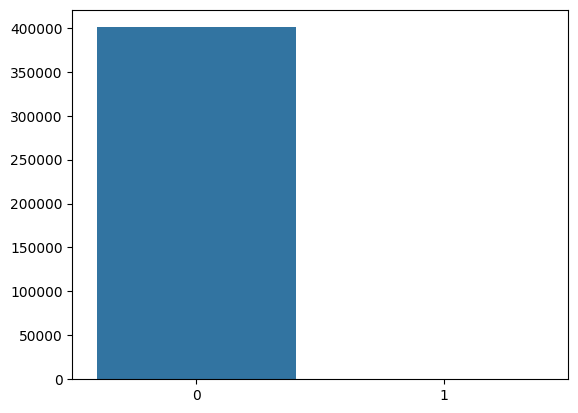

In [40]:
sns.barplot(x=list(imbalance_data.keys()), y=list(imbalance_data.values()))

In [41]:
min_count = 60000
resampled_0 = train[train['target'] == 0].groupby('target').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
undersampled_data = pd.concat([resampled_0, train[train['target'] == 1]])

print(undersampled_data['target'].value_counts())

target
0    60000
1      393
Name: count, dtype: int64


<h2>Generate New Datas</h2>

In [42]:
undersampled_data.columns

Index(['isic_id', 'target', 'age_approx', 'sex', 'clin_size_long_diam_mm',
       'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C',
       'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext',
       'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean',
       'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'mel_thick_mm',
       'tbp_lv_dnn_lesion_confidence', 'anatom_site_general_anterior torso',
       'anatom_site_general_head/neck', 'anatom_site_general_lower extremity',
       'anatom_site_general_posterior torso',
       'anatom_site_general_upper extremity', 'tbp_tile_type_3D:

<h2>For Image Feature Extractions</h2>

In [43]:
parent_path_img = rf"datasets\ISIC\train-image\image"

In [44]:
undersampled_data['isic_id'] = [ os.path.join(parent_path_img, path) for path in undersampled_data['isic_id'] ]
undersampled_data.head()

,isic_id,target,age_approx,sex,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,...,tbp_tile_type_3D: XP,tbp_tile_type_3D: white,tbp_lv_location_simple_Head & Neck,tbp_lv_location_simple_Left Arm,tbp_lv_location_simple_Left Leg,tbp_lv_location_simple_Right Arm,tbp_lv_location_simple_Right Leg,tbp_lv_location_simple_Torso Back,tbp_lv_location_simple_Torso Front,tbp_lv_location_simple_Unknown
0,datasets\ISIC\train-image\image\ISIC_6396320.jpg,0,65.0,1.0,4.66,21.394360,16.854730,31.273710,29.082740,37.89147,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,datasets\ISIC\train-image\image\ISIC_3201049.jpg,0,65.0,1.0,3.97,20.946960,11.705450,37.648790,30.706400,43.08371,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,datasets\ISIC\train-image\image\ISIC_4340911.jpg,0,65.0,1.0,4.92,22.299969,16.726375,24.308931,22.492868,32.98807,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,datasets\ISIC\train-image\image\ISIC_0974527.jpg,0,50.0,1.0,3.08,26.624380,24.296910,30.566320,30.361220,40.53588,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,datasets\ISIC\train-image\image\ISIC_5870890.jpg,0,60.0,1.0,3.84,24.305920,16.166490,33.199900,29.853600,41.14621,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [45]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [46]:
image_paths = undersampled_data['isic_id'].tolist()
labels = undersampled_data['target'].tolist()
    


In [47]:
device = torch.device("cuda", 0)

googlenet = (models.googlenet(pretrained=True)).to(device)
googlenet.fc = torch.nn.Linear(1024, len(set(labels))).to(device)
googlenet.fc

Linear(in_features=1024, out_features=2, bias=True)

In [48]:
retrain_model = False

if retrain_model:
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])    

    dataset = CustomDataset(image_paths=image_paths, labels=labels, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(googlenet.parameters(), lr=0.001, momentum=0.9)
    
    for epoch in range(1):  # Number of epochs
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            
            optimizer.zero_grad()               # Zero the parameter gradients
            
            outputs = googlenet(inputs)         # Forward pass
            loss = criterion(outputs, labels)
            
            loss.backward()                     # Backward pass and optimize
            optimizer.step()

            
            running_loss += loss.item()         # Print statistics
            if i % 100 == 0:  
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0
    
    model_save_path = 'isic_maul.pth'
    torch.save(googlenet.state_dict(), model_save_path)
        

In [49]:
class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])  # Exclude the final layer

    def forward(self, x):
        x = self.features(x)
        return x

#feature_extractor = FeatureExtractor(googlenet).to(device)

In [50]:
model = FeatureExtractor(googlenet).to(device)

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



In [53]:
features_dict = {}
for i, path in tqdm.tqdm(enumerate(undersampled_data['isic_id'])):
    #print(i)
    img = Image.open(path)
    img_t = preprocess(img)
    batch_t = torch.unsqueeze(img_t, 0).to(device)
    #with torch.no_grad():
    features = model(batch_t)
    listed_feature = features.detach().cpu().numpy().tolist()
    for j, feat in enumerate(listed_feature[0]):
        if f'feature_{j}' in features_dict:
            features_dict[f'feature_{j}'].append(feat[0][0])
        else:
            features_dict[f'feature_{j}'] = [feat[0][0]]  
 
    

60393it [34:25, 29.24it/s]


In [57]:
for val in features_dict:
    undersampled_data[val] = features_dict[val]
    
undersampled_data

,isic_id,target,age_approx,sex,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,...,feature_1014,feature_1015,feature_1016,feature_1017,feature_1018,feature_1019,feature_1020,feature_1021,feature_1022,feature_1023
0,datasets\ISIC\train-image\image\ISIC_4890631.jpg,0,30.0,0.0,3.10,22.658126,19.606697,27.859849,27.027117,35.910470,...,0.000000,0.512752,0.489400,0.543431,0.509797,0.523205,0.460333,0.541010,0.477438,0.500355
1,datasets\ISIC\train-image\image\ISIC_6072342.jpg,0,75.0,1.0,4.73,13.385030,10.512710,20.030850,20.300170,24.091360,...,0.488870,0.568440,0.000000,0.519445,0.000000,0.510601,0.519225,0.509226,0.484782,0.516244
2,datasets\ISIC\train-image\image\ISIC_1912409.jpg,0,35.0,1.0,4.17,17.934603,11.625846,28.000881,27.969512,33.252058,...,0.542405,0.529819,0.511424,0.545807,0.000000,0.540240,0.538550,0.000000,0.503597,0.000000
3,datasets\ISIC\train-image\image\ISIC_4318468.jpg,0,50.0,0.0,4.30,18.435970,14.441566,26.082292,24.264426,31.940115,...,0.542853,0.522298,0.000000,0.000000,0.000000,0.472122,0.486736,0.479243,0.479675,0.488546
4,datasets\ISIC\train-image\image\ISIC_4818967.jpg,0,55.0,1.0,2.51,18.922380,15.867490,34.655980,33.097580,39.485350,...,0.558228,0.527709,0.507417,0.532915,0.000000,0.500222,0.501445,0.000000,0.508057,0.526583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396165,datasets\ISIC\train-image\image\ISIC_9877311.jpg,1,50.0,0.0,8.16,17.351658,11.348823,23.910937,24.652597,29.543408,...,0.000000,0.000000,0.000000,0.544979,0.502339,0.000000,0.512705,0.512336,0.515755,0.000000
398671,datasets\ISIC\train-image\image\ISIC_9941636.jpg,1,60.0,0.0,5.65,21.990980,14.083370,34.254300,33.717530,40.705780,...,0.527833,0.521604,0.522817,0.552157,0.550389,0.543437,0.000000,0.557834,0.442191,0.500095
399936,datasets\ISIC\train-image\image\ISIC_9972649.jpg,1,60.0,1.0,8.51,19.003400,11.828330,21.741510,23.470120,28.875990,...,0.000000,0.509263,0.539260,0.550536,0.539013,0.523509,0.000000,0.486903,0.520460,0.507173
399943,datasets\ISIC\train-image\image\ISIC_9972877.jpg,1,65.0,0.0,12.08,23.465230,18.400280,17.359240,20.595300,29.188360,...,0.000000,0.520862,0.529955,0.569684,0.000000,0.501390,0.480414,0.577505,0.488914,0.495678


In [58]:
# save a checkpoint
undersampled_data.to_csv("undersampled_data.csv", index=False)

<h2>Import Saved Data</h2>

In [2]:
undersampled_data = pd.read_csv("undersampled_data.csv")
undersampled_data.head()

,isic_id,target,age_approx,sex,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,...,feature_1014,feature_1015,feature_1016,feature_1017,feature_1018,feature_1019,feature_1020,feature_1021,feature_1022,feature_1023
0,datasets\ISIC\train-image\image\ISIC_4890631.jpg,0,30.0,0.0,3.10,22.658126,19.606697,27.859849,27.027117,35.910470,...,0.000000,0.512752,0.489400,0.543431,0.509797,0.523205,0.460333,0.541010,0.477438,0.500355
1,datasets\ISIC\train-image\image\ISIC_6072342.jpg,0,75.0,1.0,4.73,13.385030,10.512710,20.030850,20.300170,24.091360,...,0.488870,0.568440,0.000000,0.519445,0.000000,0.510601,0.519225,0.509226,0.484782,0.516244
2,datasets\ISIC\train-image\image\ISIC_1912409.jpg,0,35.0,1.0,4.17,17.934603,11.625846,28.000881,27.969512,33.252058,...,0.542405,0.529819,0.511424,0.545807,0.000000,0.540240,0.538550,0.000000,0.503597,0.000000
3,datasets\ISIC\train-image\image\ISIC_4318468.jpg,0,50.0,0.0,4.30,18.435970,14.441566,26.082292,24.264426,31.940115,...,0.542853,0.522298,0.000000,0.000000,0.000000,0.472122,0.486736,0.479243,0.479675,0.488546
4,datasets\ISIC\train-image\image\ISIC_4818967.jpg,0,55.0,1.0,2.51,18.922380,15.867490,34.655980,33.097580,39.485350,...,0.558228,0.527709,0.507417,0.532915,0.000000,0.500222,0.501445,0.000000,0.508057,0.526583


<h2>Data Generation</h2>

In [3]:
from imblearn.over_sampling import BorderlineSMOTE

X_train = undersampled_data[[column for column in undersampled_data.columns if column not in ['target', 'isic_id']]]
y_train = undersampled_data['target']

smote_border = BorderlineSMOTE(random_state = 42, kind = 'borderline-2')
X_smoteborder, y_smoteborder = smote_border.fit_resample(X_train, y_train)

In [4]:
X_smoteborder

,age_approx,sex,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,...,feature_1014,feature_1015,feature_1016,feature_1017,feature_1018,feature_1019,feature_1020,feature_1021,feature_1022,feature_1023
0,30.000000,0.000000,3.100000,22.658126,19.606697,27.859849,27.027117,35.910470,33.389933,50.878900,...,0.000000,0.512752,0.489400,0.543431,0.509797,0.523205,0.460333,0.541010,0.477438,0.500355
1,75.000000,1.000000,4.730000,13.385030,10.512710,20.030850,20.300170,24.091360,22.860760,56.248330,...,0.488870,0.568440,0.000000,0.519445,0.000000,0.510601,0.519225,0.509226,0.484782,0.516244
2,35.000000,1.000000,4.170000,17.934603,11.625846,28.000881,27.969512,33.252058,30.289501,57.360382,...,0.542405,0.529819,0.511424,0.545807,0.000000,0.540240,0.538550,0.000000,0.503597,0.000000
3,50.000000,0.000000,4.300000,18.435970,14.441566,26.082292,24.264426,31.940115,28.236877,54.745856,...,0.542853,0.522298,0.000000,0.000000,0.000000,0.472122,0.486736,0.479243,0.479675,0.488546
4,55.000000,1.000000,2.510000,18.922380,15.867490,34.655980,33.097580,39.485350,36.704600,61.365190,...,0.558228,0.527709,0.507417,0.532915,0.000000,0.500222,0.501445,0.000000,0.508057,0.526583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,63.592084,1.000000,4.075814,21.335720,19.217574,21.247563,22.637318,30.160514,29.720241,44.764116,...,0.456283,0.503714,0.461993,0.532090,0.487487,0.525270,0.486795,0.072190,0.484801,0.510587
119996,69.920494,1.000000,18.887337,23.202865,15.291617,21.348701,19.801748,31.530518,25.018864,42.612488,...,0.498127,0.562262,0.542661,0.527006,0.508025,0.546226,0.003376,0.517799,0.480542,0.516679
119997,47.367816,0.157854,6.782682,22.306976,17.724591,15.276863,18.302270,27.076218,25.527012,34.347753,...,0.082480,0.534113,0.069349,0.542836,0.536930,0.079477,0.496403,0.513370,0.472007,0.516558
119998,39.148159,0.914816,14.332263,15.160633,11.552923,18.823457,23.154095,24.180485,25.878178,51.019203,...,0.046985,0.042800,0.506556,0.515470,0.043012,0.526625,0.518364,0.550133,0.044377,0.463978


In [5]:
y_smoteborder

0         0
1         0
2         0
3         0
4         0
         ..
119995    1
119996    1
119997    1
119998    1
119999    1
Name: target, Length: 120000, dtype: int64

<h2>Apply Feature Selection</h2>

In [6]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

model_lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)
model_lsvc.fit(X_smoteborder, y_smoteborder)
sel_feature = SelectFromModel(model_lsvc, prefit=True)

In [7]:
X_smoteborder.iloc[:,sel_feature.get_support()]

,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,...,feature_990,feature_991,feature_994,feature_995,feature_996,feature_1006,feature_1014,feature_1015,feature_1017,feature_1022
0,30.000000,3.100000,22.658126,19.606697,27.859849,27.027117,50.878900,54.041166,44.773357,52.700071,...,0.545600,0.473249,0.546513,0.539778,0.000000,0.516207,0.000000,0.512752,0.543431,0.477438
1,75.000000,4.730000,13.385030,10.512710,20.030850,20.300170,56.248330,62.622020,30.096720,35.205500,...,0.555191,0.000000,0.000000,0.558877,0.549008,0.496897,0.488870,0.568440,0.519445,0.484782
2,35.000000,4.170000,17.934603,11.625846,28.000881,27.969512,57.360382,67.429232,44.164063,54.532935,...,0.521353,0.534720,0.506584,0.543478,0.000000,0.517301,0.542405,0.529819,0.545807,0.503597
3,50.000000,4.300000,18.435970,14.441566,26.082292,24.264426,54.745856,59.239974,23.679937,29.885847,...,0.548349,0.541106,0.472556,0.539281,0.547983,0.509396,0.542853,0.522298,0.000000,0.479675
4,55.000000,2.510000,18.922380,15.867490,34.655980,33.097580,61.365190,64.386220,55.818820,62.131140,...,0.521620,0.000000,0.515690,0.515429,0.513413,0.000000,0.558228,0.527709,0.532915,0.508057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,63.592084,4.075814,21.335720,19.217574,21.247563,22.637318,44.764116,49.610156,42.893851,58.445703,...,0.075357,0.538490,0.489358,0.508301,0.546134,0.074334,0.456283,0.503714,0.532090,0.484801
119996,69.920494,18.887337,23.202865,15.291617,21.348701,19.801748,42.612488,52.325378,28.684555,38.104500,...,0.494090,0.507767,0.503407,0.524681,0.539378,0.528330,0.498127,0.562262,0.527006,0.480542
119997,47.367816,6.782682,22.306976,17.724591,15.276863,18.302270,34.347753,45.881983,41.705751,53.774984,...,0.509691,0.542100,0.492887,0.087400,0.549204,0.506724,0.082480,0.534113,0.542836,0.472007
119998,39.148159,14.332263,15.160633,11.552923,18.823457,23.154095,51.019203,63.475899,19.174175,36.746783,...,0.560267,0.479892,0.544100,0.500651,0.045519,0.530549,0.046985,0.042800,0.515470,0.044377


In [8]:
X_filtered = X_smoteborder.iloc[:,sel_feature.get_support()]

<h2>Build Classification Model</h2>

In [9]:
set_data = xgb.DMatrix(X_filtered, label=y_smoteborder, enable_categorical=True)
params = {            
            'objective': 'binary:hinge',
            'tree_method':'hist',
            "booster": "dart",
            "device": "cuda",
            'alpha_val': 9.748257290831706,
            'colsample_bytree': 0.5665975854252202,
            "gamma":0.001,
            "lambda":0.0001,
            'eta': 0.17852662342285394,
            'max_depth': 10,
            'min_child_weight': 10,
            'n_estimators': 3586,
            'subsample': 0.4091759812425272       
        }
model = xgb.train(params, set_data, num_boost_round=1500)

In [10]:
model.save_model("models/ISIC_model_2024.json")

In [16]:
feature_list = X_filtered.columns
filename = 'models/ISIC_model_2024.txt'

# Open the file in write mode ('w'), which will create the file if it doesn't exist
with open(filename, 'w') as file:
    # Write the text data to the file
    file.write(", ".join(feature_list))

In [13]:
model_predict = xgb.Booster()
model_predict.load_model("models/ISIC_model_2024.json")
model_predict

In [14]:
with open('models/ISIC_model_2024.txt', 'r') as file:
    
    feature_list = file.readlines() 

In [22]:
feature_list[0].split(", ")

['age_approx',
 'clin_size_long_diam_mm',
 'tbp_lv_A',
 'tbp_lv_Aext',
 'tbp_lv_B',
 'tbp_lv_Bext',
 'tbp_lv_H',
 'tbp_lv_Hext',
 'tbp_lv_L',
 'tbp_lv_Lext',
 'tbp_lv_areaMM2',
 'tbp_lv_area_perim_ratio',
 'tbp_lv_deltaA',
 'tbp_lv_deltaL',
 'tbp_lv_deltaLB',
 'tbp_lv_deltaLBnorm',
 'tbp_lv_nevi_confidence',
 'tbp_lv_norm_color',
 'tbp_lv_perimeterMM',
 'tbp_lv_radial_color_std_max',
 'tbp_lv_stdL',
 'tbp_lv_stdLExt',
 'tbp_lv_symm_2axis_angle',
 'tbp_lv_x',
 'tbp_lv_y',
 'tbp_lv_z',
 'mel_thick_mm',
 'tbp_lv_dnn_lesion_confidence',
 'anatom_site_general_anterior torso',
 'anatom_site_general_head/neck',
 'anatom_site_general_lower extremity',
 'tbp_tile_type_3D: white',
 'tbp_lv_location_simple_Head & Neck',
 'tbp_lv_location_simple_Left Leg',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_15',
 'feature_20',
 'feature_24',
 'feature_25',
 'feature_33',
 'feature_36',
 'feature_45',
 'feature_52',
 'feature_58',
 'feature_59',
 'feature_63',
 'feature_70',
 'feature_72',
 'featur

In [23]:
feature_list = [str(val) for val in feature_list[0].split(", ")]
feature_list

['age_approx',
 'clin_size_long_diam_mm',
 'tbp_lv_A',
 'tbp_lv_Aext',
 'tbp_lv_B',
 'tbp_lv_Bext',
 'tbp_lv_H',
 'tbp_lv_Hext',
 'tbp_lv_L',
 'tbp_lv_Lext',
 'tbp_lv_areaMM2',
 'tbp_lv_area_perim_ratio',
 'tbp_lv_deltaA',
 'tbp_lv_deltaL',
 'tbp_lv_deltaLB',
 'tbp_lv_deltaLBnorm',
 'tbp_lv_nevi_confidence',
 'tbp_lv_norm_color',
 'tbp_lv_perimeterMM',
 'tbp_lv_radial_color_std_max',
 'tbp_lv_stdL',
 'tbp_lv_stdLExt',
 'tbp_lv_symm_2axis_angle',
 'tbp_lv_x',
 'tbp_lv_y',
 'tbp_lv_z',
 'mel_thick_mm',
 'tbp_lv_dnn_lesion_confidence',
 'anatom_site_general_anterior torso',
 'anatom_site_general_head/neck',
 'anatom_site_general_lower extremity',
 'tbp_tile_type_3D: white',
 'tbp_lv_location_simple_Head & Neck',
 'tbp_lv_location_simple_Left Leg',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_15',
 'feature_20',
 'feature_24',
 'feature_25',
 'feature_33',
 'feature_36',
 'feature_45',
 'feature_52',
 'feature_58',
 'feature_59',
 'feature_63',
 'feature_70',
 'feature_72',
 'featur

<h2>Test</h2>

In [70]:
import random

In [76]:
rand_ind = random.randint(1, 9999)
test = train.iloc[rand_ind:rand_ind+1]

In [77]:
test

,isic_id,target,age_approx,sex,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,...,tbp_tile_type_3D: XP,tbp_tile_type_3D: white,tbp_lv_location_simple_Head & Neck,tbp_lv_location_simple_Left Arm,tbp_lv_location_simple_Left Leg,tbp_lv_location_simple_Right Arm,tbp_lv_location_simple_Right Leg,tbp_lv_location_simple_Torso Back,tbp_lv_location_simple_Torso Front,tbp_lv_location_simple_Unknown
7731,ISIC_0263792.jpg,0,55.0,1.0,3.52,25.02173,22.25292,31.21274,34.93653,40.00403,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [79]:
features_dict = {}

#print(i)
img = Image.open(os.path.join(parent_path_img, (test.isic_id.iloc[0])))
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0).to(device)
#with torch.no_grad():
features = model(batch_t)
listed_feature = features.detach().cpu().numpy().tolist()
for j, feat in enumerate(listed_feature[0]):
    if f'feature_{j}' in features_dict:
        features_dict[f'feature_{j}'].append(feat[0][0])
    else:
        features_dict[f'feature_{j}'] = [feat[0][0]]

In [80]:
for feature in features_dict:
    test[feature] = features_dict[feature]
test

,isic_id,target,age_approx,sex,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,...,feature_1014,feature_1015,feature_1016,feature_1017,feature_1018,feature_1019,feature_1020,feature_1021,feature_1022,feature_1023
7731,ISIC_0263792.jpg,0,55.0,1.0,3.52,25.02173,22.25292,31.21274,34.93653,40.00403,...,0.568523,0.506445,0.490347,0.541531,0.512036,0.51558,0.516559,0.0,0.48362,0.0


In [81]:
test = test[feature_list]
test

,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,...,feature_990,feature_991,feature_994,feature_995,feature_996,feature_1006,feature_1014,feature_1015,feature_1017,feature_1022
7731,55.0,3.52,25.02173,22.25292,31.21274,34.93653,51.28255,57.50479,32.12812,45.53906,...,0.550021,0.551663,0.501474,0.544784,0.517018,0.510798,0.568523,0.506445,0.541531,0.48362


In [82]:

prediction = model_predict.predict(xgb.DMatrix(test.values.reshape(1,-1), enable_categorical=True, feature_names=feature_list))
prediction

array([0.], dtype=float32)

<h2>Apply on Test Dataset</h2>

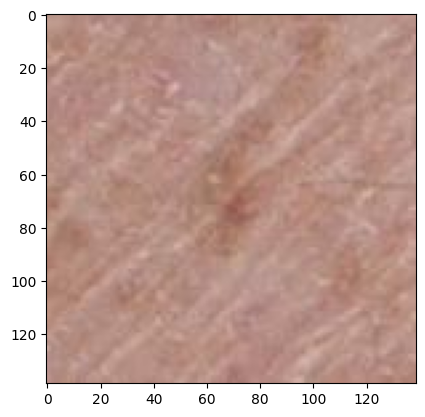

In [13]:
## example of plotting the image
plt.imshow(mpimg.imread(os.path.join(parent_path_img, train['isic_id'].iloc[0])))